## Kaggle 2019 Toxic Challenge

Incomplete missing a lot of write up and clean up, but this was for learning purposes and it was fun to implement a new method that is very competitive with the leading scores. There is a ~2% difference in subgroup accuracy score on the public leaderboards. I would need to add a couple more scoring metrics to see where my model begins to over fit the subgroup accuracy or put in my own custom lost function within the fastai it's still a challenge for me. 

### Data Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

### Helper Functions

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000): 
            display(df)

### Data Loading & EDA

**Note** 

Most of what is below was after creating a very strong MVP model for this competition and the cleaning of the corpus wasn't used for the ``Fastai`` approach. This could easily create some small or significant increases in the score recieved from the modeling approach. 

The EDA and custom features are something that I might go ahead and work with later on at some point. My thought process is to ensemble to created tabular model with the text modeling apporach. I am still looking into how to achieve that, but once that apporach is in a MVP stage I will post that as well. 

In [4]:
PATH = 'data/'

df_train = pd.read_csv(f'{PATH}train.csv')
df_test = pd.read_csv(f'{PATH}test.csv')

In [16]:
display_all(df_train.head())

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,BCE_Target
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47,1


In [52]:
display_all(df_test.head())

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [6]:
largest_sen = max(len(sen) for sen in df_train['comment_text'])
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 1906 words


In [7]:
largest_sen = max(len(sen) for sen in df_test['comment_text'])
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 1971 words


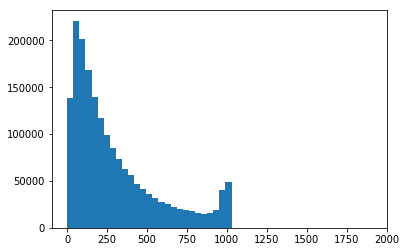

In [8]:
%matplotlib inline
plt.hist([len(sen) for sen in df_train['comment_text']], bins= 50)
plt.show()

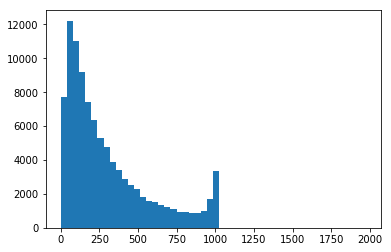

In [9]:
%matplotlib inline
plt.hist([len(sen) for sen in df_test['comment_text']], bins= 50)
plt.show()

In [10]:
train_word_count = df_train['comment_text'].str.split().apply(lambda x: len(x))
test_word_count = df_test['comment_text'].str.split().apply(lambda x: len(x))

In [11]:
maxlen = 220
print(train_word_count[train_word_count < maxlen].count()/train_word_count.count())
print(test_word_count[test_word_count < maxlen].count()/test_word_count.count())

0.9999939053917337
0.9999588984792437


In [12]:
import seaborn as sns

#### Target Feature

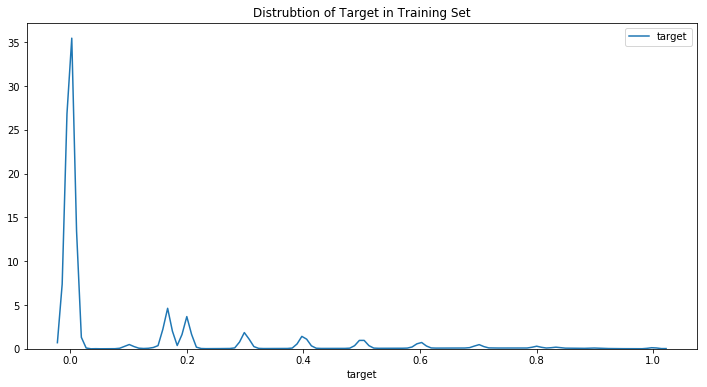

In [14]:
plt.figure(figsize=(12,6))
plt.title("Distrubtion of Target in Training Set")
sns.distplot(df_train['target'], kde=True, hist=False, bins=100, label = 'target')
plt.legend(); plt.show()

With most competition and real life scenario we have a lot of information or observations below the .50 mark where I am going to make this competition an BCE of 0 or 1 for 0 == Not toxic and 1 == Toxic

In [ ]:
df_train['BCE_Target'] = df_train.target.apply(lambda x: 0 if x <=0.5 else 1).copy()

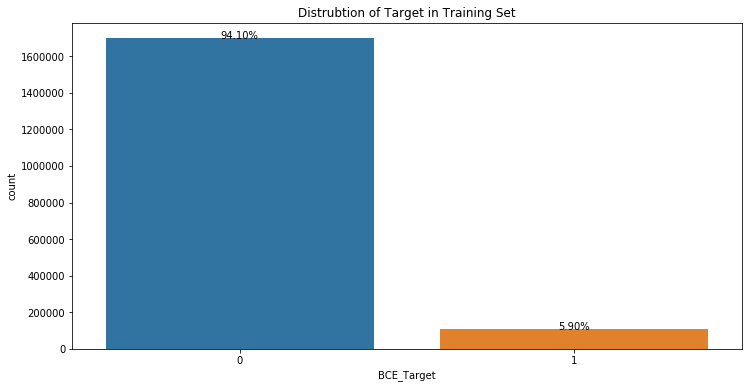

In [48]:
f, ax = plt.subplots(1,1, figsize=(12,6))
total = float(len(df_train))
g = sns.countplot(df_train['BCE_Target'], label = 'BCE_Target')
g.set_title("Distrubtion of Target in Training Set")                     
for p in ax.patches: 
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
plt.show()

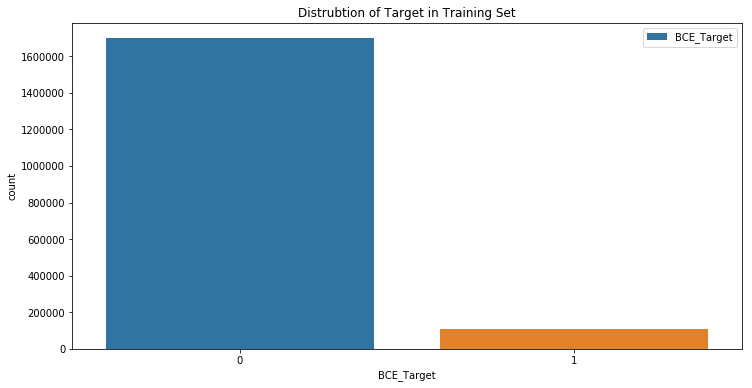

6.0% of the training data with the value 1 for the Target


In [47]:
plt.figure(figsize=(12,6))
plt.title("Distrubtion of Target in Training Set")
sns.countplot(df_train['BCE_Target'], label = 'BCE_Target')
plt.legend(); plt.show()
print("{}% of the training data with the value 1 for the Target".format(round(100 * df_train["BCE_Target"].value_counts()[1]/df_train.shape[0]),2))

#### Addtional Toxicity Features

In [25]:
def plot_feature_distrubtion(features, title, bins): 
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features: 
        sns.distplot(df_train[feature], kde=True, hist=False, bins=bins, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

/home/jdemlow/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


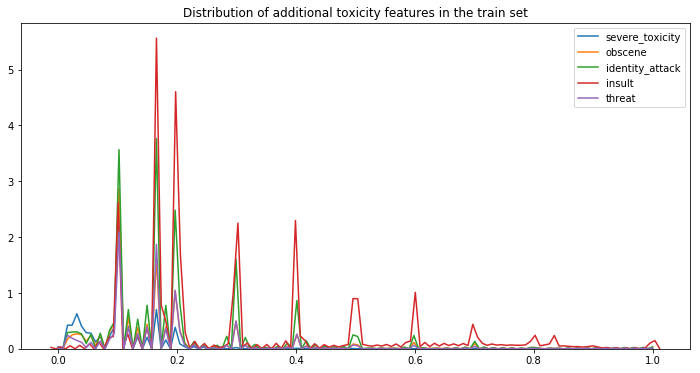

In [26]:
features = ['severe_toxicity', 'obscene','identity_attack','insult','threat']
plot_feature_distrubtion(features, "Distribution of additional toxicity features in the train set", bins=100)

In [21]:
#Simple way to look
pd.value_counts(df_train['BCE_Target'], normalize=True)

0    0.941027
1    0.058973
Name: BCE_Target, dtype: float64

In [32]:
# Convert taget and identity columns to booleans
def get_col_converted_to_bool(df, col_name):
    return np.where(df[col_name] >= 0.5, True, False)
    
def get_df_converted_categorical_cols(df, categorical_cols):
    for col in categorical_cols:
        df[col] = get_col_converted_to_bool(df, col)
    return df

def get_df_class_target_col(df, target_col, target_class_col):
    df[target_class_col] = get_col_converted_to_bool(df, target_col)
    return df

target_col_name = 'target'
target_class_col = 'class_target'
x_col_name = 'comment_text'
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian',
                    'jewish', 'muslim', 'black','white', 'psychiatric_or_mental_illness']

df_train_initial = get_df_converted_categorical_cols(df=df_train, categorical_cols=identity_columns)

df_train_initial = get_df_class_target_col(df=df_train_initial,target_col=target_col,target_class_col=target_class_col_name)

df_train = df_train_initial.copy()

In [ ]:
# def perform_preprocessing(train, test):
#     '''
#         credits to: https://www.kaggle.com/artgor/cnn-in-keras-on-folds
#         credits to: https://www.kaggle.com/taindow/simple-cudnngru-python-keras
#     '''
#     punct_mapping = {"_":" ", "`":" "}
#     punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
#     punct += '©^®` <→°€™› ♥←×§″′Â█½à…“★”–●â►−¢²¬░¶↑±¿▾═¦║―¥▓—‹─▒：¼⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸¾Ã⋅‘∞∙）↓、│（»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡√'
#     def clean_special_chars(text, punct, mapping):
#         for p in mapping:
#             text = text.replace(p, mapping[p])    
#         for p in punct:
#             text = text.replace(p, f' {p} ')     
#         return text

#     for df in [train, test]:
#         df['comment_text'] = df['comment_text'].astype(str)
#         df['comment_text'] = df['comment_text'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
    
#     return train, test

# df_train_clean, df_test_clean = perform_preprocessing(df_train, df_test)

# def preprocess(data):
#     '''
#     Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
#     '''
#     punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
#     def clean_special_chars(text, punct):
#         for p in punct:
#             text = text.replace(p, ' ')
#         return text

#     data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
#     return data

# df_train['comment_text'] = preprocess(train['comment_text'])
# df_test['comment_text'] = preprocess(test['comment_text'])

In [22]:
####THIS IS THE THING THAT FASTAI DOES FOR US
# def fixup(x):
#        x = x.replace('#39;', "'").replace('amp;', '&')
#         .replace('#146;', "'").replace('nbsp;', ' ')
#         .replace('#36;', '$').replace('\\n', "\n")
#         .replace('quot;', "'").replace('<br />', "\n")
#         .replace('\\"', '"').replace('<unk>','u_n')
#         .replace(' @.@ ','.').replace(' @-@ ','-')
#         .replace('\\', ' \\ ')
#     return re1.sub(' ', html.unescape(x))

# def get_texts(df, n_lbls=1):
#     labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
#     texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
#     for i in range(n_lbls+1, len(df.columns)): 
#         texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
#     texts = texts.apply(fixup).values.astype(str)
#     tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
#     return tok, list(labels)

# def get_all(df, n_lbls):
#     tok, labels = [], []
#     for i, r in enumerate(df):
#         print(i)
#         tok_, labels_ = get_texts(r, n_lbls)
#         tok += tok_;
#         labels += labels_
#     return tok, labels

# df_train['comment_text'] = fixup(train['comment_text'])
# df_test['comment_text'] = fixup(test['comment_text'])

In [44]:
def preprocess(data):
    '''
    Reference: https://www.kaggle.com/abhigupta4981/pytorch-train-with-callbacksandsimple-eda-text-preprocessing-jigsaw
    '''
    print("pre-processing")
    punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^','\n'
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']
    
    def clean_special_chars(text, punct):
        def get_misspell(text):
            
            contract = {"'SB91':'senate bill','tRump':'trump','utmterm':'utm term','FakeNews':'fake news','Gʀᴇat':'great','ʙᴏᴛtoᴍ':'bottom','washingtontimes':'washington times','garycrum':'gary crum','htmlutmterm':'html utm term','RangerMC':'car','TFWs':'tuition fee waiver','SJWs':'social justice warrior','Koncerned':'concerned','Vinis':'vinys','Yᴏᴜ':'you','Trumpsters':'trump','Trumpian':'trump','bigly':'big league','Trumpism':'trump','Yoyou':'you','Auwe':'wonder','Drumpf':'trump','utmterm':'utm term','Brexit':'british exit','utilitas':'utilities','ᴀ':'a', '😉':'wink','😂':'joy','😀':'stuck out tongue', 'theguardian':'the guardian','deplorables':'deplorable', 'theglobeandmail':'the globe and mail', 'justiciaries': 'justiciary','creditdation': 'Accreditation','doctrne':'doctrine','fentayal': 'fentanyl','designation-': 'designation','CONartist' : 'con-artist','Mutilitated' : 'Mutilated','Obumblers': 'bumblers','negotiatiations': 'negotiations','dood-': 'dood','irakis' : 'iraki','cooerate': 'cooperate','COx':'cox','racistcomments':'racist comments','envirnmetalists': 'environmentalists',Trump's" : 'trump is',"'cause": 'because',',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have','can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I',
    'ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat',\
    'TrumpCare':'Trump care','Trumpcare':'Trump care', 'OBAMAcare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer',\
    'ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','Sᴛᴀʀᴛ':'start','gubmit':'submit','CO₂':'carbon dioxide','ғɪʀsᴛ':'first',\
    'ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra',\
    'Gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',\
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','Mᴀᴋᴇ':'make',\
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'Maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'Sᴛaʀᴛ':' start', 'SHOPO':'shop',
    }
            for word in text.split():
                if word.lower() in contract:
                    text = text.replace(word, contract[word.lower()])
            return text
        text=get_misspell(text)    
        for p in (punct):
            text = text.replace(p,' ')
        return text
    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))

    return data

In [45]:
df_train['comment_text'] = preprocess(df_train['comment_text'].astype(str))
df_test['comment_text'] = preprocess(df_test['comment_text'].astype(str))

pre-processing
pre-processing


In [54]:
# Convert taget and identity columns to booleans
def get_col_converted_to_bool(df, col_name):
    return np.where(df[col_name] >= 0.5, True, False)
    
def get_df_converted_categorical_cols(df, categorical_cols):
    for col in categorical_cols:
        df[col] = get_col_converted_to_bool(df, col)
    return df

def get_df_class_target_col(df, target_col, target_class_col):
    df[target_class_col] = get_col_converted_to_bool(df, target_col)
    return df

target_col_name = 'target'
target_class_col = 'class_target'
x_col_name = 'comment_text'
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian',
                    'jewish', 'muslim', 'black','white', 'psychiatric_or_mental_illness']

df_train_initial = get_df_converted_categorical_cols(df=df_train, categorical_cols=identity_columns)

df_train_initial = get_df_class_target_col(df=df_train_initial,target_col=target_col,target_class_col=target_class_col_name)

df_train = df_train_initial.copy()

In [46]:
df_train['comment_text'][1]

'Thank you   This would make my life a lot less anxiety inducing  Keep it up  and do not let anyone get in your way '

In [47]:
df_test['comment_text'][1]

'I actually inspected the infrastructure on Grand Chief Stewart Philip s home Penticton First Nation in both 2010 and 2013   Exactly Zero projects that had been identified in previous inspection reports had been funded by the federal government  and the entire band was housed in ATCO trailers   Clearly the Harper Conservatives had already reduced the cash his band was sent to zero '

In [14]:
df_train['comment_text'][1]

"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!"

In [13]:
df_test['comment_text'][1]

"I actually inspected the infrastructure on Grand Chief Stewart Philip's home Penticton First Nation in both 2010 and 2013.  Exactly Zero projects that had been identified in previous inspection reports had been funded by the federal government, and the entire band was housed in ATCO trailers.  Clearly the Harper Conservatives had already reduced the cash his band was sent to zero."

In [55]:
test_text = df_test[['id','comment_text']]
train_text = df_train[['id','comment_text', 'target', 'class_target', 'male', 'female', 'homosexual_gay_or_lesbian', 'christian',
                    'jewish', 'muslim', 'black','white', 'psychiatric_or_mental_illness']]

test_text.shape, train_text.shape

((97320, 2), (1804874, 13))

In [56]:
value_10 = int(len(df_train)*.10); value_10

180487

In [57]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = value_10
n_trn = len(train_text)-n_valid
X_train, X_valid = split_vals(train_text, n_trn)
X_train.shape, X_valid.shape

((1624387, 13), (180487, 13))

In [58]:
X_train.head()

,id,comment_text,target,class_target,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
0,59848,This is so cool it is like would you want y...,0.000000,False,False,False,False,False,False,False,False,False,False
1,59849,Thank you This would make my life a lot less...,0.000000,False,False,False,False,False,False,False,False,False,False
2,59852,This is such an urgent design problem kudos t...,0.000000,False,False,False,False,False,False,False,False,False,False
3,59855,Is this something i will be able to install on...,0.000000,False,False,False,False,False,False,False,False,False,False
4,59856,haha you guys are a bunch of losers,0.893617,True,False,False,False,False,False,False,False,False,False


In [21]:
TEXT_COL = 'comment_text'

def shorten(text):
    x = text.split()
    x = x[:210]
    x = ' '.join(x)
    return x

In [30]:
sample = X_train[['id', 'comment_text']][:200]

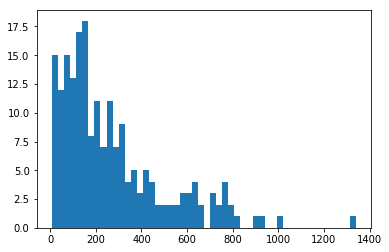

In [33]:
%matplotlib inline
plt.hist([len(sen) for sen in sample['comment_text']], bins= 50)
plt.show()

In [41]:
sample['comment_text'] = sample['comment_text'].progress_apply(lambda x: shorten(x)).copy()

100%|██████████| 200/200 [00:00<00:00, 182758.34it/s]


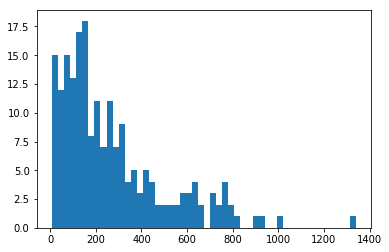

In [42]:
%matplotlib inline
plt.hist([len(sen) for sen in sample['comment_text']], bins= 50)
plt.show()

In [38]:
from tqdm import  tqdm
tqdm.pandas()

In [39]:
X_train[TEXT_COL] = X_train[TEXT_COL].progress_apply(lambda x: shorten(x))
X_valid[TEXT_COL] = X_valid[TEXT_COL].progress_apply(lambda x: shorten(x))
df_test[TEXT_COL] = df_test[TEXT_COL].progress_apply(lambda x: shorten(x))

100%|██████████| 1624387/1624387 [00:05<00:00, 315934.50it/s]
/home/jdemlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 180487/180487 [00:00<00:00, 319627.12it/s]
/home/jdemlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
100%|██████████| 97320/97320 [00:00<00:00, 313432.21it/s]


In [59]:
X_train.shape, X_valid.shape

((1624387, 13), (180487, 13))

In [60]:
X_train.head()

,id,comment_text,target,class_target,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
0,59848,This is so cool it is like would you want y...,0.000000,False,False,False,False,False,False,False,False,False,False
1,59849,Thank you This would make my life a lot less...,0.000000,False,False,False,False,False,False,False,False,False,False
2,59852,This is such an urgent design problem kudos t...,0.000000,False,False,False,False,False,False,False,False,False,False
3,59855,Is this something i will be able to install on...,0.000000,False,False,False,False,False,False,False,False,False,False
4,59856,haha you guys are a bunch of losers,0.893617,True,False,False,False,False,False,False,False,False,False


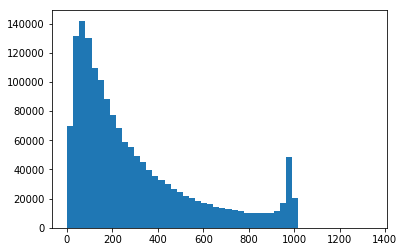

In [40]:
%matplotlib inline
plt.hist([len(sen) for sen in X_train['comment_text']], bins= 50)
plt.show()

In [43]:
# X_train.target = X_train.target.apply(lambda x: 0 if x <=0.5 else 1).copy()
# X_valid.target = X_valid.target.apply(lambda x: 0 if x <=0.5 else 1).copy()

/home/jdemlow/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [62]:
X_train.columns

Index(['id', 'comment_text', 'target', 'class_target', 'male', 'female',
       'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black',
       'white', 'psychiatric_or_mental_illness'],
      dtype='object')

### Fastai ULMFit Approach 

**Method** 

1. Train a language model on the large text corpus 

    - Accuracy of the language model was ~.32 percent and this is a good score according to Jeremy Howard and the Fastai course. This isn't supposed to take the place or a swift text or to be implemented as such it is a transfer learning approach. 
    
2. Use the encoder from the fine-tuned language model on the classification corpus as the bias of the final classification model. 

**The Language Model**

A fundamental assumption in the ULMFit is that classifying text samples requires an understanding of the language the texts are written in. In direct contrast to more traditional classification techniques like BOW and text frequency approaches, which focus on imperial data on word frequency. This type of language model trains to understand the language underlying the classification task. We use accuracy in the measurement of understanding a language. Accuracy may not be the perfect metric, but for the purpose of evaluating how well it can predict the next word is solid approach. The language model can be trained on text data outside the classification data. Barring the assumption that the language understanding is key. The model for the pretrained part is for the WikiText-103 data and this is a data set pretrained by fasted. 

**Fine Tuning the Model**

Now that the model is trained on a corpus of English with a solid accuracy giving us a sense the model understands English and the context we want to change/add more information from our corpus. There are going to be words and sentence structures that differ from the pretrained model. 

**Classification Model**

Once we have a fine-tuned language model, we can create the classification model. This involves adding a new linear layer to the language model that outputs predictions for the number of classes in the dataset. We train this model using both discriminative learning rate and gradual unfreezing. This means firstly that most of the training goes towards the new linear layer - we assume the language features extracted by the language model layers are well tuned. We also freeze most of the model at the start of training, and gradually unfreeze layers as training progresses.

**Data Preparation** 

There are endless things that we can do to preprocess data and open-ended text data leads to more possibilities. Data is wild and there are times and places to do a lot of changes. When thinking about changing the data there will be times to do this, but the idea of changing before having a good understanding can lead to bias of the PR actioner. Typically allowing the data to do the talking is my approach. This might not be the most agreed upon approach, but this is something Jeremy Howard tends to do as well and once a model is trained figuring out what drives the model will create ideas to feature engineering and other ideas. 

Text data does need to be converted to numerical form before being sent into the model. This is accomplished in two steps: 1. Tokenizing and numericizing text. Tokenization breaks up strings into word level tokens. Fastai defaults to using ``Spacy`` to tokenize text. Tokenization breaks down compound words, for example ``don't`` to ``do`` ``'nt``. Tokenizing also adds elements of sentence structure. Each sentence starts with ``xxbos`` token. Capitalized letters are denoted with a token ``xxmaj`` here ->``Here``. This way we can retain the information contained in the capitalization, but not having to track multiple versions of a word. 

When tokenizing, we also decide what vocabulary of the model will be. It's not computationally feasible to train a model using every single word in the English language. We select and default to voc = 60000 most used words in the text and replace all others with ``<unk>`` token. 

After that each token is mapped each token to a numerical id. 


**Model Architecture**

The models we use for all stages of the ULMFiT process follow the same structure, based off the approach taken in Regularizing and Optimizing LSTM Language Models [https://arxiv.org/pdf/1708.02182.pdf]. The first layer is an embedding layer which converts words to vectors. Then there are three stacked LSTM layers, followed by a linear output layer.

**The Embedding** 

The embedding layer converts discrete words to higher dimensional vector representation. The models in this notebook use vectors of length 400 to represent words. The embedding functions as a lookup table for every word in the model's vocabulary. The embedding matrix can be one of the most memory intensive aspects of the model. Therefore the size of the model's vocabulary has a strong effect on the compute cost of the model.'

**Regularization** 

The model is regularized by applying dropout at several stages - on word vectors after the embedding, on the outputs between LSTM layers, on the output of the final LSTM layer, and on the final linear layer.

**Loss Function** 

The model is trained with Cross Entropy loss

In [63]:
path = Path('data/')

In [64]:
bs=250

In [69]:
data_lm2 = TextDataBunch.from_df(path,train_df=X_train,valid_df=X_valid,test_df=df_test, label_cols='target', text_cols='comment_text')
#            .add_test(TextDataBunch.from_csv(path, 'test.csv', text_cols='comment_text'))
#            .random_split_by_pct(0.1)
#            .label_for_lm()
#            .databunch(bs=bs))     

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
data_lm2

In [ ]:
data_lm2.save('tmp_lm')

In [ ]:
data_lm.show_batch()

In [9]:
# data_lm = TextLMDataBunch.load(path, 'tmp_lm2', bs=bs)
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [10]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


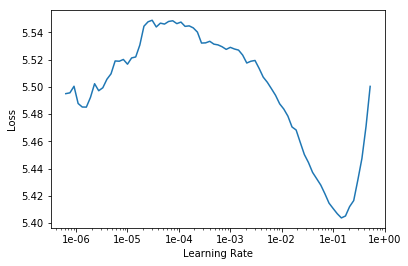

In [12]:
learn.recorder.plot(skip_end=15)

In [13]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.449511,4.336616,0.263747


In [14]:
learn.save('fit_head')

In [15]:
learn.load('fit_head');

In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.101383,4.022725,0.295567
2,3.971936,3.934030,0.305215
3,3.900672,3.872648,0.311621
4,3.842373,3.827752,0.316735


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [18]:
learn.save('fine_tuned2')

In [25]:
learn.load('fine_tuned2');

NameError: name 'learn' is not defined

In [20]:
learn.save_encoder('fine_tuned_enc2')

In [21]:
TEXT = "I liked what you did, but"
N_WORDS = 40
N_SENTENCES = 2

In [22]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked what you did, but i believe that 's what you 're thinking . xxbos xxmaj the xxup us has not yet accepted this contract . xxmaj the federal government has been doing that for years . xxmaj since then , the dividend has been
I liked what you did, but i have no idea what you mean . xxbos xxmaj the xxmaj liberal financial elite are now following the xxmaj canadian xxmaj constitution xxmaj act and the xxmaj canadian xxmaj constitution . xxmaj as a xxmaj canadian , it seems


### Classifer 

In [3]:
path = Path('data/')
PATH = 'data/'

In [ ]:
df_train = pd.read_csv(f'{PATH}train.csv')
df_test = pd.read_csv(f'{PATH}test.csv')

In [ ]:
df_train.target = df_train.target.apply(lambda x: 0 if x <=0.5 else 1).copy()

In [ ]:
pd.value_counts(df_train.target)

In [ ]:
# df_train.to_csv(f'{PATH}train_target.csv')

In [ ]:
df_train.head()

In [41]:
train_text = df_train[['id','comment_text', 'target']]
train_text.shape

(1804874, 3)

In [42]:
value_10 = int(len(df_train)*.10); value_10

180487

In [43]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = value_10
n_trn = len(df_train)-n_valid
X_train, X_valid = split_vals(df_train, n_trn)
X_train.shape, X_valid.shape

((1624387, 45), (180487, 45))

In [34]:
bs=64

In [35]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm2', bs=bs)

You can deactivate this warning by passing `no_check=True`.


/home/jdemlow/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py:226: UserWarning: There seems to be something wrong with your dataset, can't access these elements in self.train_ds: 0
  warn(warn_msg)


In [50]:
data_class = (
            TextDataBunch.from_csv(path, 'train_target.csv', valid_pct=0.1, vocab=data_lm.vocab,
                                   text_cols='comment_text', label_cols='target', test='test.csv')
             )                        
# data_class = TextDataBunch.from_df(path,train_df=X_train,valid_df=X_valid,test_df=df_test, 
#                                  label_cols='target', text_cols='comment_text', vocab=data_lm.vocab)

In [ ]:
data_class.save('tmp_class')

In [10]:
x,y = next(iter(data_class.valid_dl))

In [4]:
bs = 200
data_class = TextClasDataBunch.load(path, 'tmp_class', bs=bs)
data_class.show_batch()

text,target
xxbos xxmaj local candidate # 1 ... \n xxrep 11 ┈ xxrep 13 ? \n ┈ ┈ ╱ xxrep 5 ▔ ╲ ┈ ┈ ┈ xxrep 10 ? \n ┈ ╱ ┈ ┈ ╱ ▔ ╲ ╲ ╲ ▏ ┈ ┈ ┈ xxrep 5 ? ┈ \n ╱ ┈ ┈ ╱ ━ ╱ xxrep 5 ▔ ╲ ━ ╮ ┈ ┈ \n ▏ ┈ ▕ xxunk ▕ ╱ ▔,0
xxbos xxmaj the xxup rusting xxup rail was a failure before the first fake ground breaking with xxup xxunk xxmaj remember xxup him ? ? ? xxmaj when they said they needed to start xxup rail in a empty field 2 miles short of xxmaj kapolei the failure began and it has steamrolled since . xxmaj from 2.7 xxup billion xxup to 3.5 xxup billion xxup to 5.2 xxup billion,0
"xxbos xxmaj see ya , xxmaj kevin , thanks for all the great xxmaj bronco memories . i 'll never forget that time you ... eh ... that time you ... well ... didn't suit up for a game . xxmaj you take care of yourself , now . xxmaj see ya at your xxmaj induction at the xxmaj hall . xxmaj what a loser . i 'm so glad",0
"xxbos xxmaj our humble scribe xxmaj dr. xxmaj professor xxmaj doug xxmaj saunders writes of xxmaj le xxmaj pen senior xxrep 4 . "" xxmaj his height of power came in 2002 , when disarray on the xxmaj french left led him to win the first - round presidential election , triggering a national crisis and a concerted multi - party effort to keep his party out of mainstream politics",0
"xxbos i do n't know any 4th century xxmaj greek , so i do n't know . \n\n xxmaj the xxmaj french xxmaj catholic is "" de même nature que le xxmaj père "" ( same nature ) . xxmaj the xxmaj greek xxmaj orthodox use "" one essence . "" xxmaj in my view , these preserve the individuality of the xxmaj father and xxmaj son , so one",0


In [5]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_target, last_output, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            self.learn.recorder.add_metrics([metric])

In [6]:
learn = text_classifier_learner(data_class, max_len=210, metrics=[accuracy], callback_fns=[ShowGraph, AUROC], drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [ ]:
# learn.save('base_learner')

In [7]:
learn.freeze()

This is the classifier model. You will notice that everything is the same as the language model except the final section of linear layers. We directly load in the weights from the language model into the embedding/LSTM section of this model.

The linear head on the classifier is called a PoolingLinearClassifier. This is a bit more sophistocated than a typical linear layer. The final output from the final LSTM is a 1x400 vector. However the output also contains all the hidden states from the various words that passed through the model before the final word. fastai's PoolingLinearClassifier takes these previous hidden states and performs max pooling and average pooling over them to produce two additional 1x400 vectors. These three output vectors are then concatenated together to form a single 1x1200 vector. This is what is actually sent to the final linear layers.

In [8]:
learn.model

SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60003, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60003, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


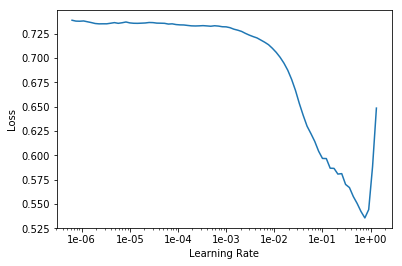

In [9]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,AUROC
1,0.170536,0.161603,0.944888,0.874022


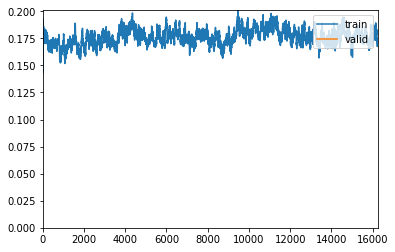

In [11]:
#Discriminative learning rates and graudal unfreezing
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

In [12]:
learn.save('head_trained2')
# learn.load('head_trained')

epoch,train_loss,valid_loss,accuracy,AUROC
1,0.111043,0.100939,0.963460,0.960884


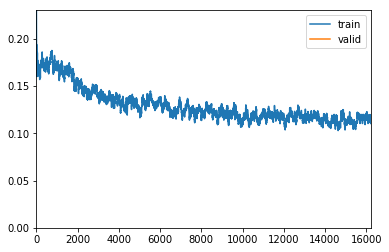

In [13]:
#unfreeze the final LSTM only. We train the LSTM layer at lower learning rate than the linear head
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [20]:
#unfreeze the final LSTM only. We train the LSTM layer at lower learning rate than the linear head
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.111438,0.098439,0.963654


In [14]:
learn.save('first_LSTM2')
# learn.load('first_LSTM')

epoch,train_loss,valid_loss,accuracy,AUROC
1,0.103688,0.090068,0.966796,0.969464


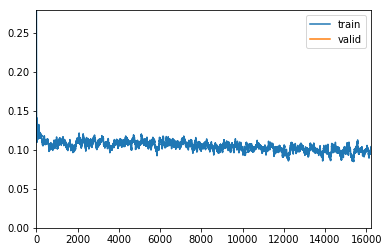

In [15]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [16]:
learn.save('second_LSTM2')
# learn.load('second_LSTM')

epoch,train_loss,valid_loss,accuracy,AUROC
1,0.091037,0.088681,0.966552,0.970395
2,0.089426,0.085593,0.967566,0.971638
3,0.081500,0.085549,0.967904,0.971942


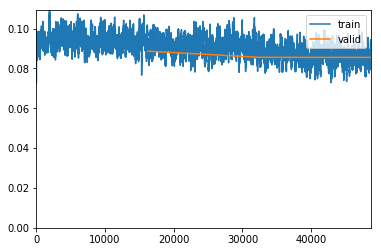

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [18]:
learn.save('full_LSTM2')
# learn.load('full_LSTM')

In [72]:
# learn.save('full_LSTM')
learn.load('full_LSTM')

### Predictions

In [19]:
test_preds = learn.get_preds(DatasetType.Test, ordered=True)

In [20]:
oof = learn.get_preds(ds_type=DatasetType.Valid)

In [21]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [22]:
o = oof[0].cpu().data.numpy()
l = oof[1].cpu().data.numpy()

In [23]:
accuracy_score(l,o[:,1]>0.5), roc_auc_score(l,o[:,1])

(0.9679036833473693, 0.971942229520415)

FROM [https://www.kaggle.com/nholloway/the-effect-of-word-embeddings-on-bias]

Not Used, but this will show accuracy of the subgroups what the kaggle comp is rating us on this could be something to add to call backs if I could figure this out. This might be a good thing to implement with the pre-processing with the model length of time it takes to run this might be a side project in the future. This is also something I want to implement is a custom loss function in fastai with this type of cutting edge method. 

   - Subgroup AUC: The AUC score for the entire subgroup- a low score hear means the model fails to distinguish between toxic and non-toxic comments that mention this identity.
   - BPSN AUC: Background positive, subgroup negative. A low value here means the model confuses non-toxic examples that mention the identity with toxic examples that do not.
   - BNSP AUC: Background negative, subgroup positive. A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not.

In [ ]:
# FROM https://www.kaggle.com/nholloway/the-effect-of-word-embeddings-on-bias
# Not Used, but this will show accuracy of the subgroups what the kaggle comp is rating us on
IDENTITY_COLUMNS = ['black', 'white', 'male', 'female', 'homosexual_gay_or_lesbian',
                   'christian', 'jewish', 'muslim', 'psychiatric_or_mental_illness'] 
    
def compute_bpsn_auc(df, subgroup, model, label):
    subgroup_positive_examples = df.loc[(df[subgroup] == 1) & (df[label] == 1)]
    non_subgroup_negative_examples = df.loc[df[subgroup] != 1 & (df[label] == 0)]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return auc(examples[label], examples[model])  
    
def compute_bnsp_auc(df, subgroup, model, label):
    subgroup_negative_examples = df.loc[(df[subgroup] == 1) & (df[label] == 0)]
    non_subgroup_positive_examples = df.loc[(df[subgroup] != 1) & (df[label] == 1)]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return auc(examples[label], examples[model])

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total/len(series), 1/p)

def compute_final_bias(bias_df, overall_auc, power=-5, overall_model_weight=0.25):
    bias_score = np.average([
        power_mean(bias_df['subgroup_auc'], power),
        power_mean(bias_df['bpsn_auc'], power),
        power_mean(bias_df['bnsp_auc'], power)
    ])
    return (overall_model_weight * overall_auc) + ((1 - overall_model_weight)* bias_score)
    
def compute_subgroup_bias_metrics(df, subgroups, model, label):
    records = []
    for subgroup in subgroups:
        subgroup_df = df.loc[df[subgroup] == 1]
        record = {
            'subgroup': subgroup, 
            'subgroup_size': len(subgroup_df)
        }
        record['subgroup_auc'] = auc(subgroup_df['target'], subgroup_df[model])
        record['bpsn_auc'] = compute_bpsn_auc(df, subgroup, model, label)
        record['bnsp_auc'] = compute_bnsp_auc(df, subgroup, model, label)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

In [63]:
accuracy_score(l,o[:,1]>0.5), roc_auc_score(l,o[:,1])

(0.9671889543903196, 0.9726968226442432)

In [24]:
p = test_preds[0].cpu().data.numpy()

In [25]:
test_preds[0].data.numpy().T[0]

array([0.997462, 0.999896, 0.996693, 0.997926, ..., 0.999011, 0.993987, 0.991328, 0.998203], dtype=float32)

In [26]:
test_preds[0].argmax(1).numpy()

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

In [27]:
df_sub = pd.read_csv(f'{PATH}sample_submission.csv')

In [28]:
df_submission =df_sub[['id']]

In [29]:
df_submission['prediction'] = p[:,1] #test_preds[0].data.numpy().T[0]

In [70]:
df_submission.head(50)

,id,prediction
0,7000000,0.010577
1,7000001,0.000121
2,7000002,0.000732
3,7000003,0.002101
4,7000004,0.972327
5,7000005,0.000224
6,7000006,0.000361
7,7000007,0.000472
8,7000008,0.001090
9,7000009,0.009139


In [30]:
df_submission.head(50)

,id,prediction
0,7000000,0.002538
1,7000001,0.000104
2,7000002,0.003306
3,7000003,0.002074
4,7000004,0.980998
5,7000005,0.000077
6,7000006,0.000186
7,7000007,0.001875
8,7000008,0.002732
9,7000009,0.006695


**Kaggle Public Score**

The above approach is a pretty standard apporach using the ULMFit approach that Fastai has created and allowed for the public to use. 
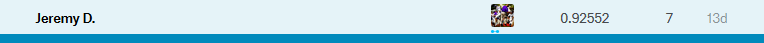

In [31]:
df_submission.to_csv('submissionfullwhoknows2.csv', index=False)

In [56]:
learn.predict("""Jeff Sessions is another one of Trump's Orwellian choices. He believes and has believed his entire career the exact opposite of what the position requires.""")

(Category 0, tensor(0), tensor([0.9911, 0.0089]))

In [32]:
learn.predict("""Jeff Sessions is another one of Trump's Orwellian choices. He believes and has believed his entire career the exact opposite of what the position requires.""")

(Category 0, tensor(0), tensor([0.9855, 0.0145]))